In [13]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [14]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import jsonify


In [16]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [17]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with = engine)

In [18]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [19]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create a session
session = Session(engine)

In [21]:
#Give the first row
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b2794591e0>,
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01'}

# Exploratory Precipitation Analysis

In [51]:
# Find the most recent date in the data set.
first_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
first_date[0]

'2017-08-23'

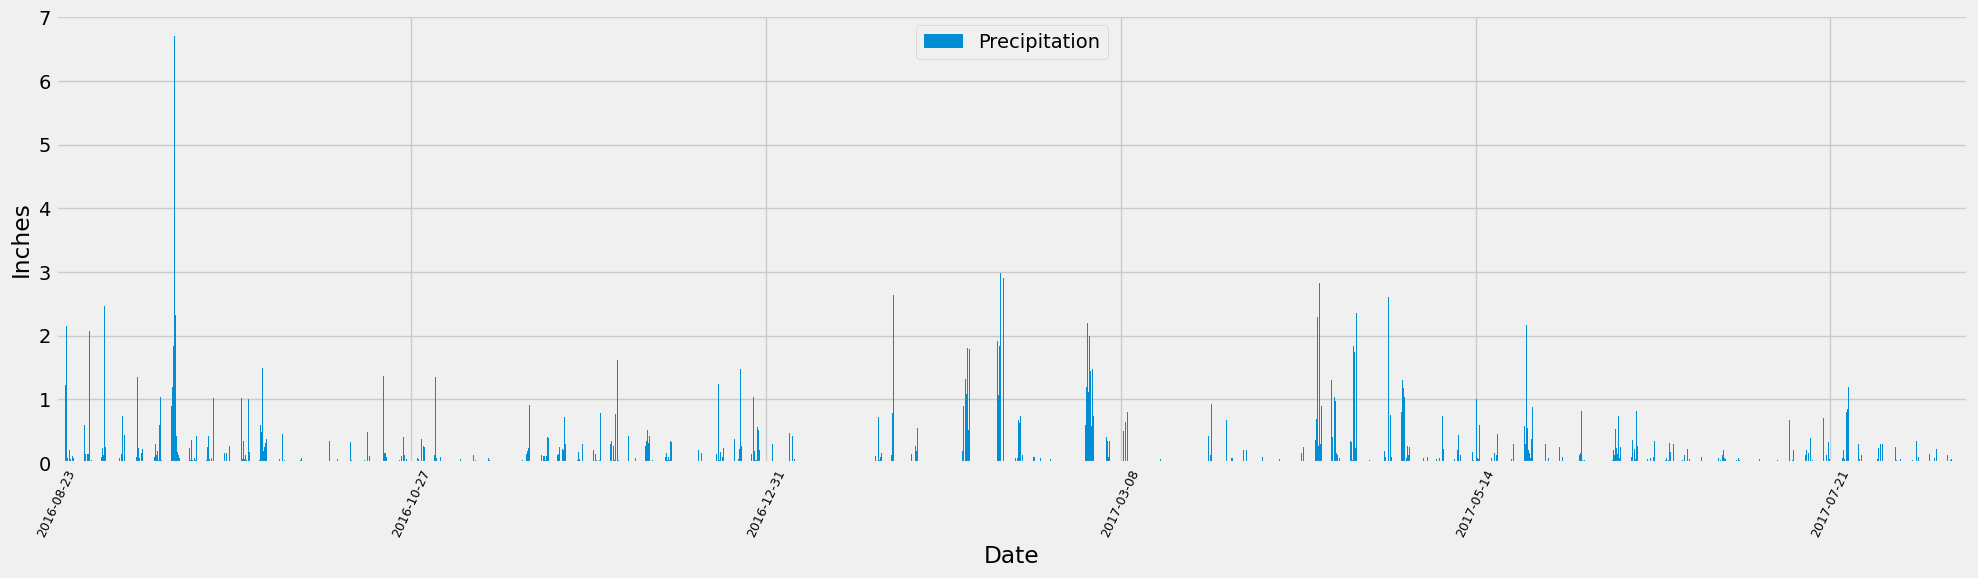

In [49]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
sel = [Measurement.date , Measurement.prcp]

# Perform a query to retrieve the data and precipitation scores
query = session.query(*sel).filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
pscores = pd.DataFrame(query , columns = ["Date","Precipitation"])

# Sort the dataframe by date
pscores = pscores.sort_values("Date" , ascending = True)
pscores.dropna(inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = pscores.plot(kind = 'bar',figsize = (20,6), xticks = np.arange(0,2229,375))
plt.xlabel("Date")
plt.ylabel("Inches")
ax.set_xticklabels([pscores["Date"].iloc[j] for j in np.arange(0,2229,375)])
plt.xticks(rotation = 65 , fontsize = 9)
plt.legend(loc = 'upper center')
plt.tight_layout()
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
pscores["Precipitation"].describe().to_frame()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [25]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(func.count(Station.station)).all()
stations

[(9,)]

In [26]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
newsel = [Measurement.station , func.count(Measurement.station)]

activity = session.query(*newsel).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
tempq = session.query(func.min(Measurement.tobs) , func.max(Measurement.tobs) , func.avg(Measurement.tobs)).\
filter(Measurement.station == 'USC00519281').all()
tempq

[(54.0, 85.0, 71.66378066378067)]

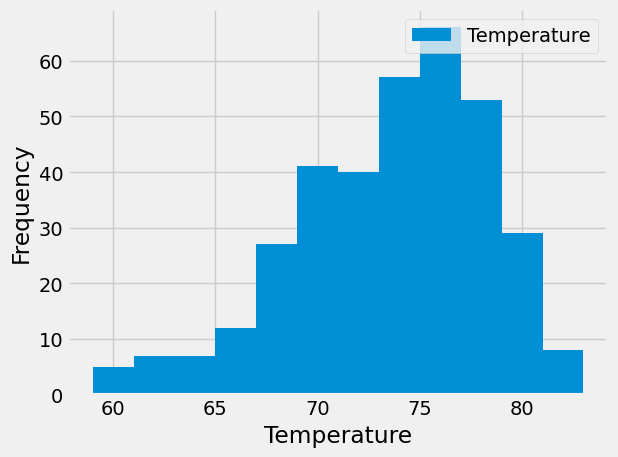

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

freqq = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= '2016-08-23').all()
freqdf = pd.DataFrame(freqq , columns = ["Temperature"])
freqdf.plot(kind = 'hist' , bins = 12)
#freqdf
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Close Session

In [29]:
# Close Session
#session.close()


# Query testing for Flask API Section

In [30]:
#Query testing for Flask API Section
# Return a JSON list of stations from the dataset.
stationsquery = session.query(Station.station).all()
stationdict = {}
for idx , station in enumerate(stationsquery):
    stationdict[f"Station {idx}"] = station[0]

stationdict

{'Station 0': 'USC00519397',
 'Station 1': 'USC00513117',
 'Station 2': 'USC00514830',
 'Station 3': 'USC00517948',
 'Station 4': 'USC00518838',
 'Station 5': 'USC00519523',
 'Station 6': 'USC00519281',
 'Station 7': 'USC00511918',
 'Station 8': 'USC00516128'}

In [31]:
#Query the dates and temperature observations of the most-active station for the previous year of data.
#Return a JSON list of temperature observations for the previous year.
Q = [Measurement.date , Measurement.tobs]
dto = session.query(*Q).filter(Measurement.date >= '2016-08-23').filter(Measurement.station == 'USC00519281').all()
dtodict = {}
for row in dto:
    (date , tobs) = row
    dtodict[date] = tobs

dtodict

{'2016-08-23': 77.0,
 '2016-08-24': 77.0,
 '2016-08-25': 80.0,
 '2016-08-26': 80.0,
 '2016-08-27': 75.0,
 '2016-08-28': 73.0,
 '2016-08-29': 78.0,
 '2016-08-30': 77.0,
 '2016-08-31': 78.0,
 '2016-09-01': 80.0,
 '2016-09-02': 80.0,
 '2016-09-03': 78.0,
 '2016-09-04': 78.0,
 '2016-09-05': 78.0,
 '2016-09-06': 73.0,
 '2016-09-07': 74.0,
 '2016-09-08': 80.0,
 '2016-09-09': 79.0,
 '2016-09-10': 77.0,
 '2016-09-11': 80.0,
 '2016-09-12': 76.0,
 '2016-09-13': 79.0,
 '2016-09-14': 75.0,
 '2016-09-15': 79.0,
 '2016-09-16': 78.0,
 '2016-09-17': 79.0,
 '2016-09-18': 78.0,
 '2016-09-19': 78.0,
 '2016-09-20': 76.0,
 '2016-09-21': 74.0,
 '2016-09-22': 77.0,
 '2016-09-23': 78.0,
 '2016-09-24': 79.0,
 '2016-09-25': 79.0,
 '2016-09-26': 77.0,
 '2016-09-27': 80.0,
 '2016-09-28': 78.0,
 '2016-09-29': 78.0,
 '2016-09-30': 78.0,
 '2016-10-01': 77.0,
 '2016-10-02': 79.0,
 '2016-10-03': 79.0,
 '2016-10-04': 79.0,
 '2016-10-05': 79.0,
 '2016-10-06': 75.0,
 '2016-10-07': 76.0,
 '2016-10-08': 73.0,
 '2016-10-09'